# Capstone: Number transcription from images
### Preprocess

Goal is to recognize and transcribe numbers of varying length from real-world images.

In [73]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import scipy.io as sio
import h5py
import random
import pprint
import cv2

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

ImportError: No module named cv2

First download the SVHN dataset. 73257 digits for training, 26032 digits for testing

In [3]:
# format 2
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('train_32x32.mat', 182040794)
test_filename = maybe_download('test_32x32.mat', 64275384)
extra_filename = maybe_download('extra_32x32.mat', 1329278602)

('Found and verified', 'train_32x32.mat')
('Found and verified', 'test_32x32.mat')
('Found and verified', 'extra_32x32.mat')


In [3]:
# format 1
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('train.tar.gz', 404141560)
test_filename = maybe_download('test.tar.gz', 276555967)
extra_filename = maybe_download('extra.tar.gz', 1955489752)


('Found and verified', 'train.tar.gz')
('Found and verified', 'test.tar.gz')
('Found and verified', 'extra.tar.gz')


In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)
extra_folders = maybe_extract(extra_filename)

Extracting data for train. This may take a while. Please wait.


Exception: Expected 10 folders, one per class. Found 0 instead.

In [47]:
def get_mat_contents(matfile):
    # call in .mat file format 1
    cur_dir = r'C:\Users\kenny\Documents\Udacity\Deep learning\test'
    os.chdir(cur_dir)

    f = h5py.File(matfile,'r')
    print f
    group = f.get('digitStruct')
    print group
    data = group.items()
    print data
    name = group.get('name')
    name_arr = np.array(name)
    print 'Name shape:', name_arr.shape
    bbox = group.get('bbox')
    bbox_arr = np.array(bbox)
    print 'bbox shape:', bbox_arr.shape
    return f, name_arr, bbox_arr

test_f, test_name_arr, test_bbox_arr = get_mat_contents('digitStruct.mat')

# https://www.getdatajoy.com/learn/Read_and_Write_HDF5_from_Python

<HDF5 file "digitStruct.mat" (mode r)>
<HDF5 group "/digitStruct" (2 members)>
[(u'bbox', <HDF5 dataset "bbox": shape (13068, 1), type "|O">), (u'name', <HDF5 dataset "name": shape (13068, 1), type "|O">)]
Name shape: (13068L, 1L)
bbox shape: (13068L, 1L)


In [67]:
### create np.ndarray with .mat file data
def create_array(array, data_type, d2=0, d3=0):
    if d2 == 0:
        empty_array = np.ndarray((array.shape[0], 1), data_type)
    else:
        empty_array = np.ndarray((array.shape[0], d2, d3), data_type)
    return empty_array


#np.count_nonzero(mat_data[0])

In [72]:
def create_name_array(name_arr):
    img_array = create_array(name_arr, data_type=object)
    
    for index in range(name_arr.shape[0]):
        n_img = f[name_arr[index][0]]
        #print n_img
        n_arr = np.array(n_img)

        text = ""
        for i in range(len(n_arr)):
            num = n_arr[i][0]
            char = chr(num)
            text += char
        #print text
        img_array[index,0] = text
    return img_array

test_img_array = create_name_array(test_name_arr)
#print test_img_array[-5:]

[['13064.png']
 ['13065.png']
 ['13066.png']
 ['13067.png']
 ['13068.png']]


In [ ]:
## crop the images to the bbox


In [46]:
address_len = 6
bbox_dims = 5

def create_bbox_array(bbox_arr):
    bbox_ndarray = create_array(bbox_arr, np.float32, d2=address_len, d3=bbox_dims)
    print 'bbox_ndarray:', bbox_ndarray.shape
    
    for index in range(bbox_arr.shape[0]):
        b_img = f[bbox_arr[index][0]]
        dsets = b_img.items()
        #print b_img
        #print dsets

        name_list = []
        for name in dsets:
            dname = name[0]
            name_list.append(dname)
        #print '\n',name_list

        for i,v in enumerate(name_list):
            dataset = b_img.get(v)
            dataset_arr = np.array(dataset)
            for j in range(len(dataset_arr)):
                ref = dataset_arr[j][0]
                if len(dataset_arr) == 1:
                    bbox_ndarray[index,j,i] = ref
                    #print 'img{}-{},digit{}: {}'.format(index,v,j,ref)
                else:
                    d = b_img[ref]
                    dp = np.array(d)[0][0]
                    bbox_ndarray[index,j,i] = dp
                    #print 'img{}-{},digit{}: {}'.format(index,v,j,dp)
    return bbox_ndarray

test_bbox_ndarray = create_bbox_array(test_bbox_arr)                    
#print test_bbox_ndarray[-5:]

[[  33.    1.  227.   43.   22.]
 [  33.   10.  248.   34.   26.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]]


In [4]:
def make_array(matfile):
    mat_contents = sio.loadmat(matfile)
    print 'Matfile {} \n    keys:'.format(matfile), mat_contents.keys()
    data = mat_contents['X']
    data = np.rollaxis(data, 3)
    labels = mat_contents['y']
    print '    Data shape: {}'.format(data.shape)
    print '    Labels shape: {}'.format(labels.shape)
    print '    Data mean:', np.mean(data)
    print '    Data std deviation: {}\n'.format(np.std(data))
    return data, labels

train_data_orig, train_labels_orig = make_array('train_32x32.mat')
test_data_orig, test_labels_orig = make_array('test_32x32.mat')
extra_data_orig, extra_labels_orig = make_array('extra_32x32.mat')

Matfile train_32x32.mat 
    keys: ['y', 'X', '__version__', '__header__', '__globals__']
    Data shape: (73257, 32, 32, 3)
    Labels shape: (73257, 1)
    Data mean: 115.111779669
    Data std deviation: 50.8192679062

Matfile test_32x32.mat 
    keys: ['y', 'X', '__version__', '__header__', '__globals__']
    Data shape: (26032, 32, 32, 3)
    Labels shape: (26032, 1)
    Data mean: 116.781171171
    Data std deviation: 57.3763665964

Matfile extra_32x32.mat 
    keys: ['y', 'X', '__version__', '__header__', '__globals__']
    Data shape: (531131, 32, 32, 3)
    Labels shape: (531131, 1)
    Data mean: 110.588958251
    Data std deviation: 50.4875521768



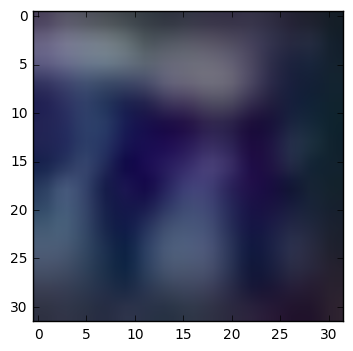

Label: [7]




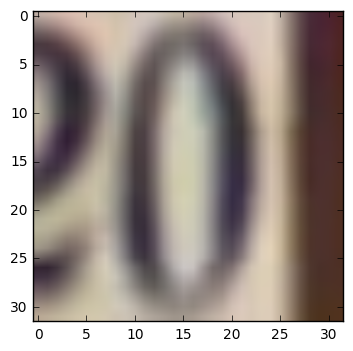

Label: [10]




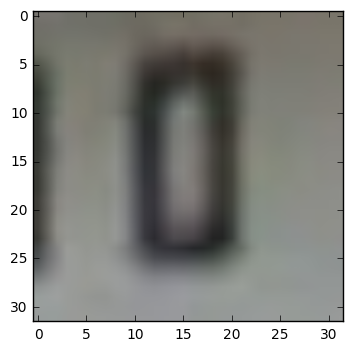

Label: [10]




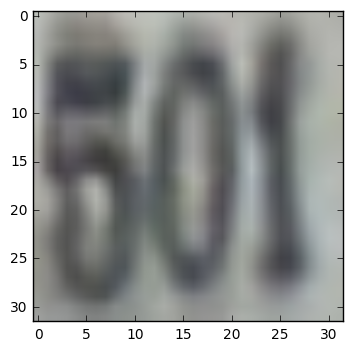

Label: [10]




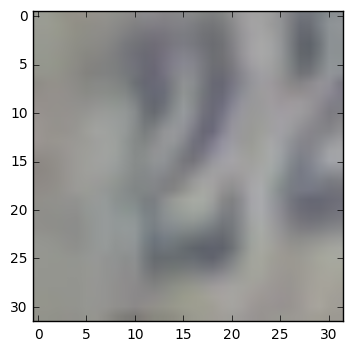

Label: [2]




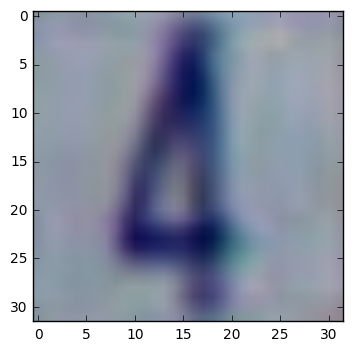

Label: [4]




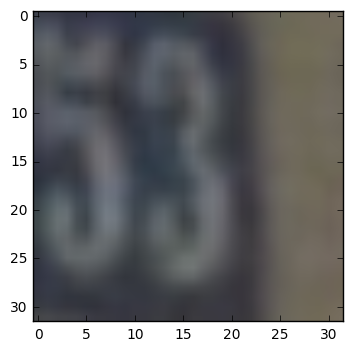

Label: [3]




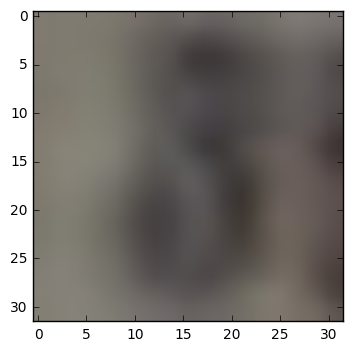

Label: [3]




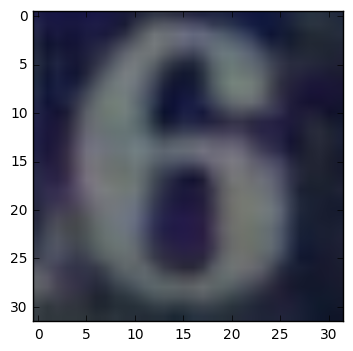

Label: [6]




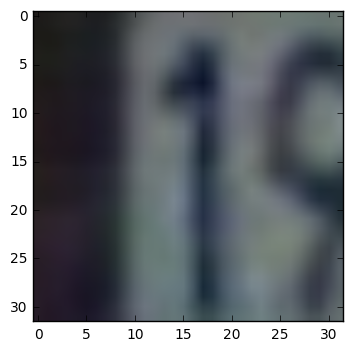

Label: [1]




In [5]:
# check to make sure the data still looks good & compare to its label
for i in range(10):
    index = random.randint(0,train_data_orig.shape[0])
    picindex = train_data_orig[index]
    plt.imshow(picindex)
    plt.show()
    print 'Label: {}\n\n'.format(train_labels_orig[index])

In [6]:
# Convert all arrays to grayscale and normalized to have 
# approximately zero mean and standard deviation ~0.5

image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
def create_gray(name, four_dim_array):
    print 'Original shape: {}'.format(four_dim_array.shape )

    dataset = np.ndarray(shape=(len(four_dim_array), image_size, image_size),
                         dtype=np.float32)
    for index in range(len(four_dim_array)):
        picindex = four_dim_array[index]
        gray = picindex[:,:,0]
        dataset[index] = gray
    print 'New shape: {}\n'.format(dataset.shape)
    return dataset


def norm_array(name, four_dim_array):
    print '{} mean: {}'.format(name, np.mean(four_dim_array))
    print '{} std deviation: {}'.format(name, np.std(four_dim_array))
    
    data_gray = create_gray(name, four_dim_array) 
    
    # normalize here
    dataset = np.ndarray(shape=(len(data_gray), image_size, image_size),
                     dtype=np.float32)
    for index in range(len(data_gray)):
        image_data = (data_gray[index] - pixel_depth / 2) / (pixel_depth/2.0)
        dataset[index, :, :] = image_data
        #dataset[index, :, :] = np.linalg.norm(data_gray[index])
    
    print '{}_norm mean: {}'.format(name, np.mean(dataset))
    print '{}_norm std deviation: {}'.format(name, np.std(dataset))
    print '{}_norm shape: {}\n\n\n'.format(name, dataset.shape)
    
    return dataset

train_data_norm = norm_array('train_data', train_data_orig)
test_data_norm = norm_array('test_data', test_data_orig)
extra_data_norm = norm_array('extra_data', extra_data_orig)

train_data mean: 115.111779669
train_data std deviation: 50.8192679062
Original shape: (73257, 32, 32, 3)
New shape: (73257, 32, 32)

train_data_norm mean: -0.124635525048
train_data_norm std deviation: 0.396060198545
train_data_norm shape: (73257, 32, 32)



test_data mean: 116.781171171
test_data std deviation: 57.3763665964
Original shape: (26032, 32, 32, 3)
New shape: (26032, 32, 32)

test_data_norm mean: -0.0951536595821
test_data_norm std deviation: 0.438869029284
test_data_norm shape: (26032, 32, 32)



extra_data mean: 110.588958251
extra_data std deviation: 50.4875521768
Original shape: (531131, 32, 32, 3)
New shape: (531131, 32, 32)

extra_data_norm mean: -0.14004842937
extra_data_norm std deviation: 0.392603695393
extra_data_norm shape: (531131, 32, 32)





Before grayscale and normalize...


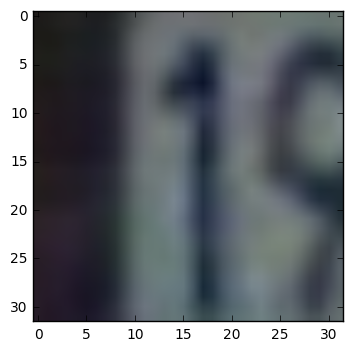

After grayscale and normalize...


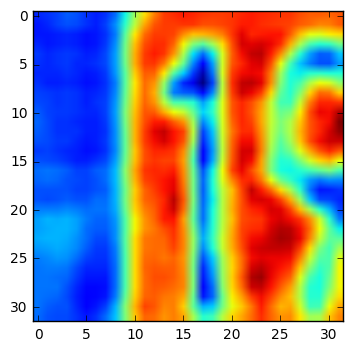

In [7]:
# show before grayscale and normalization image
print 'Before grayscale and normalize...'
picindex = train_data_orig[index]
plt.imshow(picindex)
plt.show()

# show after grayscale and normalization image
print 'After grayscale and normalize...'
picindex1 = train_data_norm[index]
plt.imshow(picindex1)
plt.show()

[[1]
 [9]
 [2]
 [3]
 [2]
 [5]
 [9]
 [3]
 [3]
 [1]]
(array([3, 7, 8]), array([0, 0, 0]))


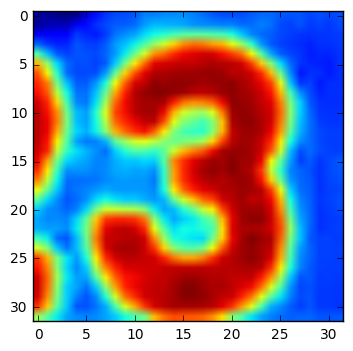

Label: [3]


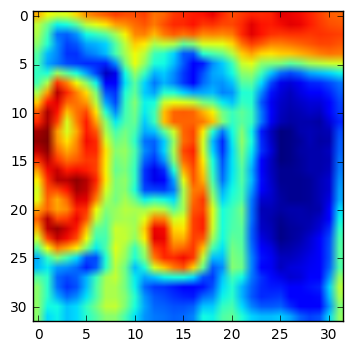

Label: [3]


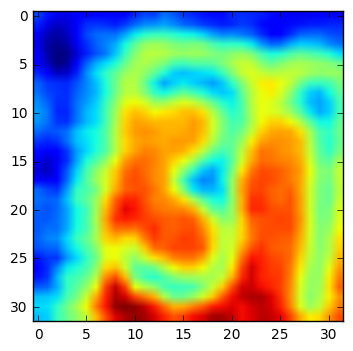

Label: [3]


In [8]:
train_test = train_data_norm[:10]
train_testl = train_labels_orig[:10]
#train_testl = train_testl.reshape(10)
print train_testl

train_index = np.where(train_testl == 3)
print train_index

train_test = train_test[train_index[0]]
train_testl = train_testl[train_index[0]]

for i in range(len(train_index[0])):
    pindex = train_test[i]
    plt.imshow(pindex)
    plt.show()
    print 'Label:', train_testl[i]

In [10]:
# find how many labels per class and total training size
v_size = 6000

label_list = [('train_labels_orig',train_labels_orig), 
              ('extra_labels_orig', extra_labels_orig)]

label_dict = dict()
for name, data in label_list:
    label_dict[name] = dict()
    for label in np.arange(1,11):
        index = np.where(data == label)
        label_dict[name][label] = len(index[0])

pp = pprint.PrettyPrinter()
pp.pprint(label_dict)

min_train = min(label_dict['train_labels_orig'].values())
min_extra = min(label_dict['extra_labels_orig'].values())
total_images = (min_train * 10) + (min_extra * 10)
train_images = total_images - v_size
print 'Training size: {} images'.format(train_images)
print 'Validation size: {} images'.format(v_size)

{'extra_labels_orig': {1: 90560,
                       2: 74740,
                       3: 60765,
                       4: 50633,
                       5: 53490,
                       6: 41582,
                       7: 43997,
                       8: 35358,
                       9: 34456,
                       10: 45550},
 'train_labels_orig': {1: 13861,
                       2: 10585,
                       3: 8497,
                       4: 7458,
                       5: 6882,
                       6: 5727,
                       7: 5595,
                       8: 5045,
                       9: 4659,
                       10: 4948}}
Training size: 385150 images
Validation size: 6000 images


In [11]:
# merge datasets and create validation set

def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(train_data, train_labels, train_size, extra_data, 
                   extra_labels, valid_size):
    valid_from_extra = 1/3.0 # percent of the validation set that comes from the extra dataset
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labelset = make_arrays(train_size, image_size)
    min_train_class_size = min(label_dict['train_labels_orig'].values())
    min_extra_class_size = min(label_dict['extra_labels_orig'].values())
    vsize_per_class_train = int(valid_size // num_classes * (1-valid_from_extra)) # 400
    vsize_per_class_extra = int(valid_size // num_classes * valid_from_extra) # 200
    tsize_per_class_train = min_train_class_size - vsize_per_class_train
    tsize_per_class_extra = min_extra_class_size - vsize_per_class_extra

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class_train, tsize_per_class_train
    
    # total size = 5,000
    # v from train = 400
    # v from extra = 200
    # t from train = 4,600 (5,000-400)
    # t from extra = 4,800 (5,000-200)
    
    for label in np.arange(1,11):
        ## split training dataset into validation and training datasets
        train_index = np.where(train_labels == label) # get indices for label
        np.random.shuffle(train_index[0]) # shuffle indices for label
        tmp_train_data = train_data[train_index[0]]
        tmp_train_labels = train_labels[train_index[0]]
        # assign first 400 images to the validation set
        valid_dataset[start_v: end_v, :, :] = tmp_train_data[:vsize_per_class_train, :, :] 
        valid_labels[start_v: end_v] = label
        start_v += vsize_per_class_train
        end_v += vsize_per_class_extra
        # assign remaining images to training dataset
        train_dataset[start_t:end_t, :, :] = tmp_train_data[
            vsize_per_class_train:min_train_class_size, :, :] 
        train_labelset[start_t:end_t] = label
        start_t += tsize_per_class_train
        end_t += tsize_per_class_extra
        
        ## split extra dataset into validation and training datasets
        extra_index = np.where(extra_labels == label) # get indices for label
        np.random.shuffle(extra_index[0]) # shuffle indices for label
        tmp_extra_data = extra_data[extra_index[0]]
        tmp_extra_labels = extra_labels[extra_index[0]]
        # assign first 200 images to the validation set
        valid_dataset[start_v: end_v, :, :] = tmp_extra_data[:vsize_per_class_extra, :, :] 
        valid_labels[start_v: end_v] = label
        start_v += vsize_per_class_extra
        end_v += vsize_per_class_train
        # assign remaining images to training dataset
        train_dataset[start_t:end_t, :, :] = tmp_extra_data[
            vsize_per_class_extra:min_extra_class_size, :, :] 
        train_labelset[start_t:end_t] = label
        start_t += tsize_per_class_extra
        end_t += tsize_per_class_train

    return valid_dataset, valid_labels, train_dataset, train_labelset
            
num_classes = 10
valid_size = v_size
train_size = train_images
valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
    train_data_norm, train_labels_orig, train_size, 
    extra_data_norm, extra_labels_orig, valid_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)


('Training:', (385150, 32, 32), (385150,))
('Validation:', (6000, 32, 32), (6000,))


In [15]:
# reshape test_labels
print test_labels_orig.shape
test_labels_orig = np.reshape(test_labels_orig, (len(test_labels_orig),))
print test_labels_orig.shape

(26032, 1)
(26032,)


In [16]:
# randomly shuffle order of datasets
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_data_norm, test_labels_orig)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Training data shape: (385150, 32, 32)
Image label: 10


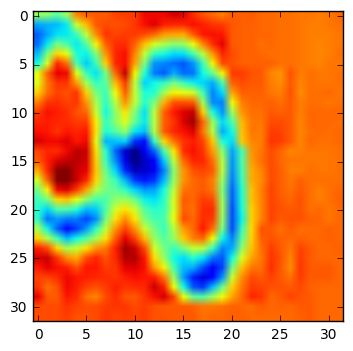

Image label: 7


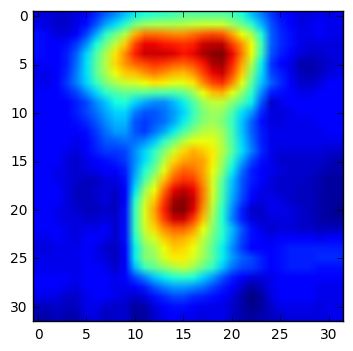

In [17]:
# Check on the data
index = [5,1300]
print 'Training data shape:', train_dataset.shape
for i in index:
    print 'Image label:', train_labels[i]
    plt.imshow(train_dataset[i])
    plt.show()

In [18]:
# save data
pickle_file = 'number_ocr.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [19]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 1710368580)
